In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.special import gammaln
import random
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [6]:
# 단어 불러오기
with open('./datasets/ap/vocab.txt', 'r') as f:
    vocab = [word.strip() for word in f]

# 문서 불러오기
articles = []
with open('./datasets/ap/ap.dat', 'r') as f:
    for line in f:
        parts = line.strip().split()
        total_words = int(parts[0])
        word_counts = Counter({int(word_count.split(':')[0]): int(word_count.split(':')[1]) for word_count in parts[1:]})
        articles.append((total_words, word_counts))

# 불용어 리스트
stopwords = set(ENGLISH_STOP_WORDS)

# 단어 빈도 계산
word_freq = defaultdict(int)
for total_words, word_counts in articles:
    for word_idx, count in word_counts.items():
        word_freq[word_idx] += count

word_freq_arr = np.array([word_freq[i] for i in range(len(vocab))])

# 빈도 기반 단어 제거
low_threshold = np.percentile(word_freq_arr, 5)
high_threshold = np.percentile(word_freq_arr, 95)
low_freq_words = set(np.where(word_freq_arr <= low_threshold)[0])
high_freq_words = set(np.where(word_freq_arr >= high_threshold)[0])

# 길이가 2이하인 단어 제거
short_words = {i for i, word in enumerate(vocab) if len(word) <= 2}

# 단어 제거 리스트 생성
words_to_remove = short_words | low_freq_words | high_freq_words | {i for i, word in enumerate(vocab) if word in stopwords}

# 단어 필터링
filtered_vocab = [word for i, word in enumerate(vocab) if i not in words_to_remove]

print(f"Filtered vocabulary list : {filtered_vocab}")

# 문서 데이터 필터링
filtered_articles = []
for total_words, word_counts in articles:
    filtered_word_counts = Counter({word_idx: count for word_idx, count in word_counts.items() if word_idx not in words_to_remove})
    filtered_total_words = sum(filtered_word_counts.values())
    filtered_articles.append((filtered_total_words, filtered_word_counts))
# 필터링된 단어 수와 문서 수 출력
print(f"Filtered number of words: {len(filtered_vocab)}")

articles = filtered_articles
# 인덱스 에러가 발생하기 때문에 단어 개수 자체, vocab은 그대로 유지해야함
num_words = len(vocab)
num_docs =len(filtered_articles)

Filtered vocabulary list : ['compared', 'cash', 'appeared', 'hearing', 'able', 'november', 'declined', 'issued', 'really', 'line', 'live', 'saudi', 'management', 'woman', 'african', 'residents', 'weapons', 'legal', 'visit', 'development', 'fighting', 'hes', 'ruling', 'injured', 'stocks', 'aug', 'angeles', 'convention', 'banks', 'signed', 'lead', 'middle', 'spent', 'ended', 'anonymity', 'effect', 'operations', 'governments', 'living', 'taxes', 'august', 'remain', 'equipment', 'jury', 'navy', 'deputy', 'parents', 'education', 'david', 'showed', 'israeli', 'immediately', 'increased', 'forced', 'clear', 'measure', 'son', 'society', 'tried', 'chicago', 'oct', 'december', 'base', 'murder', 'charge', 'primary', 'questions', 'damage', 'fair', 'seeking', 'september', 'french', 'homes', 'soviets', 'believed', 'moved', 'hundreds', 'considered', 'buy', 'staff', 'independent', 'securities', 'investment', 'nuclear', 'spoke', 'airport', 'investors', 'doesnt', 'different', 'movement', 'firm', 'killing

Iteration 1, Log-Likelihood: 12.842971418429155
Iteration 2, Log-Likelihood: 12.871418223475613
Iteration 3, Log-Likelihood: 12.897390241888548
Iteration 4, Log-Likelihood: 12.924620737310413
Iteration 5, Log-Likelihood: 12.946283007321451
Iteration 6, Log-Likelihood: 12.970711151359138
Iteration 7, Log-Likelihood: 12.991573752319066
Iteration 8, Log-Likelihood: 13.011221272515266
Iteration 9, Log-Likelihood: 13.026719676150847
Iteration 10, Log-Likelihood: 13.045415579911046
Iteration 11, Log-Likelihood: 13.058813154815015
Iteration 12, Log-Likelihood: 13.075938623617516
Iteration 13, Log-Likelihood: 13.08516165425553
Iteration 14, Log-Likelihood: 13.096758236081882
Iteration 15, Log-Likelihood: 13.106832651926561
Iteration 16, Log-Likelihood: 13.115410508947756
Iteration 17, Log-Likelihood: 13.12133724090405
Iteration 18, Log-Likelihood: 13.13197116718925
Iteration 19, Log-Likelihood: 13.136481142655418
Iteration 20, Log-Likelihood: 13.141921301087992
Iteration 21, Log-Likelihood: 13

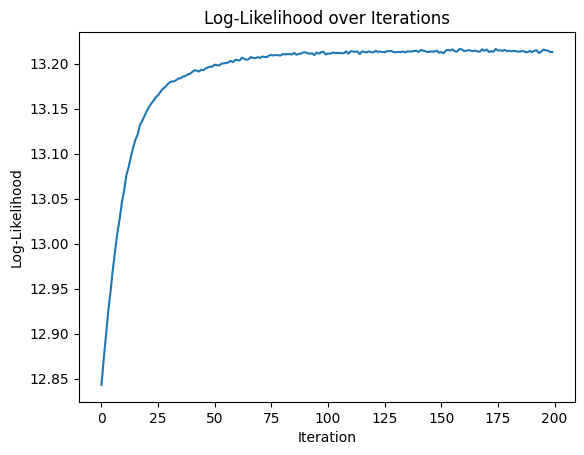

In [7]:
# 하이퍼파라미터 설정
K = 10  
# 디리클레 사전분포 하이퍼파라미터 (gamma)
gamma = 0.1  

# 감마분포 사전분포 하이퍼파라미터 (alpha)
alpha = 0.1  
beta = 0.1  
convergence_threshold = 1e-6

# 인수 초기 설정
N_dk = np.zeros((num_docs, K)) + gamma # topic별 할당된 문서의 개수
N_wk = np.zeros((K, num_words)) + beta # 토픽별 할당된 단어들의 개수
N_k = np.zeros(K) + num_words * beta # 토픽별 전체 단어들의 개수
# 최초 람다값을 감마분포의 기댓값으로 설정함. 문서 데이터의 통계량을 이용하여 초기값을 설정할 수 있음.
lambda_k = np.ones(K) * alpha / beta  

Z = []
for d, (total_words, word_counts) in enumerate(articles):
    Z_current = []
    for word_idx, count in word_counts.items():
        for _ in range(count):
            topic = random.randint(0, K - 1)
            Z_current.append(topic)
            N_dk[d, topic] += 1
            N_wk[topic, word_idx] += 1
            N_k[topic] += 1
    Z.append(Z_current)

# 반복횟수 설정
num_iterations = 200
log_likelihoods = []

# Log_likelihood 계산, Possion distribution 함수값을 모두 계산하여 더함
def compute_log_likelihood():
    ll = 0
    for k in range(K):
        ll += (alpha * np.log(beta) + (alpha - 1) * np.sum(np.log(lambda_k[k])) - beta * lambda_k[k] - gammaln(alpha))
    for d, (total_words, word_counts) in enumerate(articles):
        for word_idx, count in word_counts.items():
            theta_d = N_dk[d] / N_dk[d].sum()
            ll += count * np.log(np.dot(theta_d, lambda_k * N_wk[:, word_idx]))
    return np.log(ll) # log likelihood값이 너무 크게 계산되기 때문에 log를 할번 더 취하여 계산

previous_ll = None

for it in range(num_iterations):
    # Topic 샘플링
    for d, (total_words, word_counts) in enumerate(articles):
        Z_current = Z[d]
        for word_idx, count in word_counts.items():
            for _ in range(count):
                # d번째 데이터, w번째 단어에 해당하는 값 제외
                current_topic = Z_current.pop(0)
                N_dk[d, current_topic] -= 1
                N_wk[current_topic, word_idx] -= 1
                N_k[current_topic] -= 1

                # 조건부 확률 계산(Gamma Posterior의 기댓값을 활용한 단순화)
                topic_probs = (N_dk[d] *
                               (lambda_k * N_wk[:, word_idx]) /
                               N_k)
                topic_probs /= topic_probs.sum()

                # Topic 샘플링 : np.random.choice : Categorical distribution에서 샘플링
                new_topic = np.random.choice(K, p=topic_probs)
                Z_current.append(new_topic)
                N_dk[d, new_topic] += 1
                N_wk[new_topic, word_idx] += 1
                N_k[new_topic] += 1

        Z[d] = Z_current
    
    # lambda의 샘플링
    for k in range(K):
        lambda_k[k] = np.random.gamma(alpha + N_wk[k].sum(), 1 / (beta + N_k[k]))

    # log-likelihood 기준 convergence시 iteration중지 
    current_ll = compute_log_likelihood()
    log_likelihoods.append(current_ll)
    print(f"Iteration {it + 1}, Log-Likelihood: {current_ll}")

    if (previous_ll != None) and (abs(current_ll - previous_ll) < convergence_threshold):
        print(f"Converged after {it + 1} iterations.")
        break

    previous_ll = current_ll

# 결과저장 / Normalization
doc_topic_distr = N_dk / N_dk.sum(axis=1, keepdims=True)
topic_word_distr = N_wk / N_wk.sum(axis=1, keepdims=True)

# Log-Likelihood 시각화
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood over Iterations')
plt.show()

In [10]:
# 각 토픽에서 가장 확률이 높은 단어들 출력
top_words_per_topic = 10
for k in range(K):
    top_words = np.argsort(topic_word_distr[k])[-top_words_per_topic:]
    print(f"Topic {k+1}: {' '.join(vocab[word] for word in top_words)}")

Topic 1: orders quarter dow volume jones decline inflation compared cent stocks
Topic 2: alleged documents fbi testimony cocaine murder hearing criminal guilty jury
Topic 3: airlines heart researchers shuttle tests patients disease test environmental aids
Topic 4: arab middle arabia fitzwater pentagon soviets treaty panama baker saudi
Topic 5: art movie cbs friends college book parents hes mother film
Topic 6: shooting fired accident ship killing navy wounded bus airport injured
Topic 7: estate insurance loan companys savings assets cash investment firm debt
Topic 8: education poll votes gov candidates primary candidate governor voters convention
Topic 9: degrees weather coast fair residents river park damage homes rain
Topic 10: democracy republics republic korea china parliament parties movement independence african


In [22]:
# 결과 저장
np.save('./results/gamma_poisson_topic_word_distr.npy', topic_word_distr)
np.save('./results/gamma_poisson_doc_topic_distr.npy', doc_topic_distr)
np.save('./results/gamma_poisson_topic.npy', doc_topic_distr.argmax(axis=1))